# We will try tracking the hands with just 1 landmark, which will be a 3 * 2 = 6 length vector for each time step. 

In [49]:
import cv2, os 
import numpy as np 

In [50]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    """Only give the 0th landmark"""

    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence)  
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 2
    Y_locations = [0] * 2
    Z_locations = [0] * 2
    if results.multi_hand_landmarks:
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                landmark = hand_landmark.landmark[i]
                X_locations[hand] = landmark.x
                Y_locations[hand] = landmark.y
                Z_locations[hand] = landmark.z
                break # take only the first landmark
            
    hands.close()
    return np.concatenate([X_locations, Y_locations, Z_locations]) 

In [60]:
"""read in all of the frames"""

SECONDS_TO_DETECT = 2 # in seconds

import os, cv2
from tqdm import tqdm 
import numpy as np

ARMFLAPPING_VIDEOS = []
CONTROL_VIDEOS = []
ARMFLAPPING_FPS = [] # store the FPS of all armflapping videos 
CONTROL_FPS = [] # store the FPS of all control videos 
for video_name in tqdm(os.listdir('behavior_data/manual_armflapping'), desc = "armflapping_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/manual_armflapping/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break  
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image) 
        
        ARMFLAPPING_VIDEOS.append(FRAMES)
        ARMFLAPPING_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")

for video_name in tqdm(os.listdir('behavior_data/manual_control'), desc = "control_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/manual_control/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break 
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image)
        
        CONTROL_VIDEOS.append(FRAMES)
        CONTROL_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")
    
len(ARMFLAPPING_VIDEOS), len(CONTROL_VIDEOS)

control_videos: 100%|██████████| 42/42 [00:03<00:00, 10.78it/s]


(59, 37)

In [61]:
# get the locations of all of the videos 

ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS = [], []
for FRAMES in tqdm(ARMFLAPPING_VIDEOS) :
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    ARMFLAPPING_LOCATIONS.append(locs)

for FRAMES in tqdm(CONTROL_VIDEOS):  
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    CONTROL_LOCATIONS.append(locs)

100%|██████████| 37/37 [02:12<00:00,  3.58s/it]


In [62]:
N = min([len(locs) for locs in [ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS]])
ARMFLAPPING_LOCATIONS = ARMFLAPPING_LOCATIONS[:N]
CONTROL_LOCATIONS = CONTROL_LOCATIONS[:N]
ARMFLAPPING_LOCATIONS = np.array(ARMFLAPPING_LOCATIONS)
CONTROL_LOCATIONS = np.array(CONTROL_LOCATIONS)

# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 6))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

padded_armflapping_locations = ARMFLAPPING_LOCATIONS
padded_control_locations = CONTROL_LOCATIONS
padded_armflapping_locations = pad(padded_armflapping_locations, maxlen = 90)
padded_control_locations = pad(padded_control_locations, maxlen = 90)
print(padded_control_locations.shape, padded_armflapping_locations.shape)
assert padded_armflapping_locations.shape == padded_control_locations.shape 

<ipython-input-62-381331460c32>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ARMFLAPPING_LOCATIONS = np.array(ARMFLAPPING_LOCATIONS)
<ipython-input-62-381331460c32>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  CONTROL_LOCATIONS = np.array(CONTROL_LOCATIONS)
37it [00:00, 18261.86it/s]
37it [00:00, 26984.74it/s](37, 90, 6) (37, 90, 6)



In [63]:
from sklearn.model_selection import train_test_split

def generate_data(ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS): 
    ARMFLAPPING_LABELS = np.ones(ARMFLAPPING_LOCATIONS.shape[0])
    CONTROL_LABELS = np.zeros(CONTROL_LOCATIONS.shape[0])
    
    # concatenate 
    data = np.concatenate([ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS])
    labels = np.concatenate([ARMFLAPPING_LABELS, CONTROL_LABELS])
    
    return data, labels 
X, y = generate_data(padded_armflapping_locations, padded_control_locations)

In [64]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

def predict_on_video(model, path): 
    test_frames = []
    import cv2 

    cap = cv2.VideoCapture(path)

    while True: 
        _, frame = cap.read() 
        if not _: break 

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = hand_locations(frame)

        test_frames.append(frame)

    test_frames = np.array([test_frames])
    test_frames = pad(test_frames, maxlen = 90)
    
    return model.predict(np.array(test_frames))

In [65]:
import random 
import tensorflow as tf 
tf.config.run_functions_eagerly(True)

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :42] # [100, 42]
        Y_locations = X[:, 42:84] # [100, 42]
        Z_locations = X[:, 84:] # [100, 42]
        
        maximum = tf.math.reduce_max(Y_locations)
        minimum = tf.math.reduce_min(Y_locations)
        if maximum == 2: 
            # get the second highest 
            values, _ = tf.nn.top_k(tf.reshape(Y_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_up = 1 - maximum # the amount it can move up 
        can_move_down = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("up")
            # move up in this case 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 42:84].assign(X[:,42:84] + move_up)

        else: 
            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 42:84].assign(X[:,42:84]-move_down)

        maximum = tf.math.reduce_max(X_locations)
        minimum = tf.math.reduce_min(X_locations)
        
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(X_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            # create a set. 
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_right = 1 - maximum 
        can_move_left = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("right")
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :42].assign(X[:,:42]+move_right)
        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :42].assign(X[:,:42]-move_left)

        
        maximum = tf.math.reduce_max(Z_locations)
        minimum = tf.math.reduce_min(Z_locations)
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(Z_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e:  
                maximum = 0 
        
        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 84:].assign(X[:,84:]+move_far)
        else: 
            # move left 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 84:].assign(X[:,84:]-move_close)

        return X


class Augmenter(tf.keras.layers.Layer): 
    def __init__(self): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            return X
        else: 
            return X 


class TTAugmenter(tf.keras.layers.Layer): 
    def __init__(self): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        
    def call(self, X):
        return tf.map_fn(_shift, X)
        
        

Epoch 1/100
2/2 [==============================] - 2s 343ms/step - loss: 0.6989 - accuracy: 0.5085 - val_loss: 0.6918 - val_accuracy: 0.6000
Epoch 2/100
2/2 [==============================] - 1s 322ms/step - loss: 0.6914 - accuracy: 0.5424 - val_loss: 0.6900 - val_accuracy: 0.4667
Epoch 3/100
2/2 [==============================] - 1s 310ms/step - loss: 0.6894 - accuracy: 0.5085 - val_loss: 0.6895 - val_accuracy: 0.4667
Epoch 4/100
2/2 [==============================] - 1s 327ms/step - loss: 0.6840 - accuracy: 0.5085 - val_loss: 0.6880 - val_accuracy: 0.4667
Epoch 5/100
2/2 [==============================] - 1s 331ms/step - loss: 0.6823 - accuracy: 0.5085 - val_loss: 0.6871 - val_accuracy: 0.4667
Epoch 6/100
2/2 [==============================] - 1s 326ms/step - loss: 0.6784 - accuracy: 0.5085 - val_loss: 0.6868 - val_accuracy: 0.4667
Epoch 7/100
2/2 [==============================] - 1s 280ms/step - loss: 0.6770 - accuracy: 0.5085 - val_loss: 0.6851 - val_accuracy: 0.4667
Epoch 8/100
2

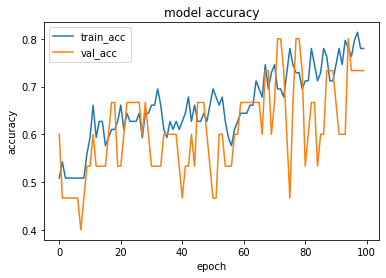

2/2 [==============================] - 0s 46ms/step - loss: 0.4249 - accuracy: 0.7966
evaluation on training data w/o augs:  [0.4249243140220642, 0.7966101765632629]
1/1 [==============================] - 0s 55ms/step - loss: 0.4829 - accuracy: 0.7333
evaluation on testing data:  [0.4829076826572418, 0.7333333492279053]


In [68]:
model = tf.keras.models.Sequential([
    Augmenter(), 
    tf.keras.layers.LSTM(64, return_sequences = False), 
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model.compile(loss = "binary_crossentropy", optimizer = "Adam", metrics = ['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100)

plot(history)

print("evaluation on training data w/o augs: ", model.evaluate(X_train, y_train))
print('evaluation on testing data: ', model.evaluate(X_test, y_test))

In [ ]:
# high validation accuracy 
# but not high testing accuracy


In [48]:
for video_name in os.listdir("behavior_data/shorter_armflapping"): 
    if video_name == ".DS_Store": continue
    print(f"for video {video_name} you get : " , predict_on_video(model, "behavior_data/shorter_armflapping/" + video_name))

1it [00:00, 15887.52it/s]
for video _75.mp4 you get :  [[0.93094015]]
1it [00:00, 3569.62it/s]
for video _61.mp4 you get :  [[0.3079691]]
1it [00:00, 18236.10it/s]
for video _49.mp4 you get :  [[0.96273625]]
1it [00:00, 21399.51it/s]
for video _48.mp4 you get :  [[0.76801085]]
1it [00:00, 12985.46it/s]
for video _60.mp4 you get :  [[0.5281691]]
1it [00:00, 16320.25it/s]
for video _74.mp4 you get :  [[0.73584974]]
1it [00:00, 5229.81it/s]
for video _62.mp4 you get :  [[0.59994614]]
1it [00:00, 3134.76it/s]
for video _76.mp4 you get :  [[0.4529897]]
1it [00:00, 19599.55it/s]
for video _89.mp4 you get :  [[0.9510293]]
1it [00:00, 18893.26it/s]
for video _88.mp4 you get :  [[0.9670545]]
1it [00:00, 1385.17it/s]
for video _77.mp4 you get :  [[0.27882868]]
1it [00:00, 2221.56it/s]
for video _63.mp4 you get :  [[0.28390935]]
1it [00:00, 1552.30it/s]
for video _67.mp4 you get :  [[0.28495604]]
1it [00:00, 1897.88it/s]
for video _73.mp4 you get :  [[0.2835219]]
1it [00:00, 19328.59it/s]
for vid